In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [22]:
# Đọc dữ liệu
df = pd.read_csv('AIDS_Classification_50000.csv')
df


,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,1073,1,37,79.46339,0,1,0,100,0,1,...,1,2,0,1,0,322,469,882,754,1
1,324,0,33,73.02314,0,1,0,90,0,1,...,1,3,1,1,1,168,575,1035,1525,1
2,495,1,43,69.47793,0,1,0,100,0,1,...,1,1,0,0,0,377,333,1147,1088,1
3,1201,3,42,89.15934,0,1,0,100,1,1,...,1,3,0,0,0,238,324,775,1019,1
4,934,0,37,137.46581,0,1,0,100,0,0,...,0,3,0,0,1,500,443,1601,849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,953,3,46,61.28204,0,0,0,90,0,1,...,1,3,0,1,1,234,402,481,1014,0
49996,1036,0,42,73.36768,0,1,0,100,0,1,...,1,3,0,0,1,369,575,514,657,0
49997,1157,0,40,78.75824,0,1,0,100,0,1,...,1,1,0,1,0,308,663,1581,863,0
49998,596,0,31,52.20371,0,0,0,100,0,1,...,1,1,0,1,1,349,440,470,865,1


In [23]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti',
             'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

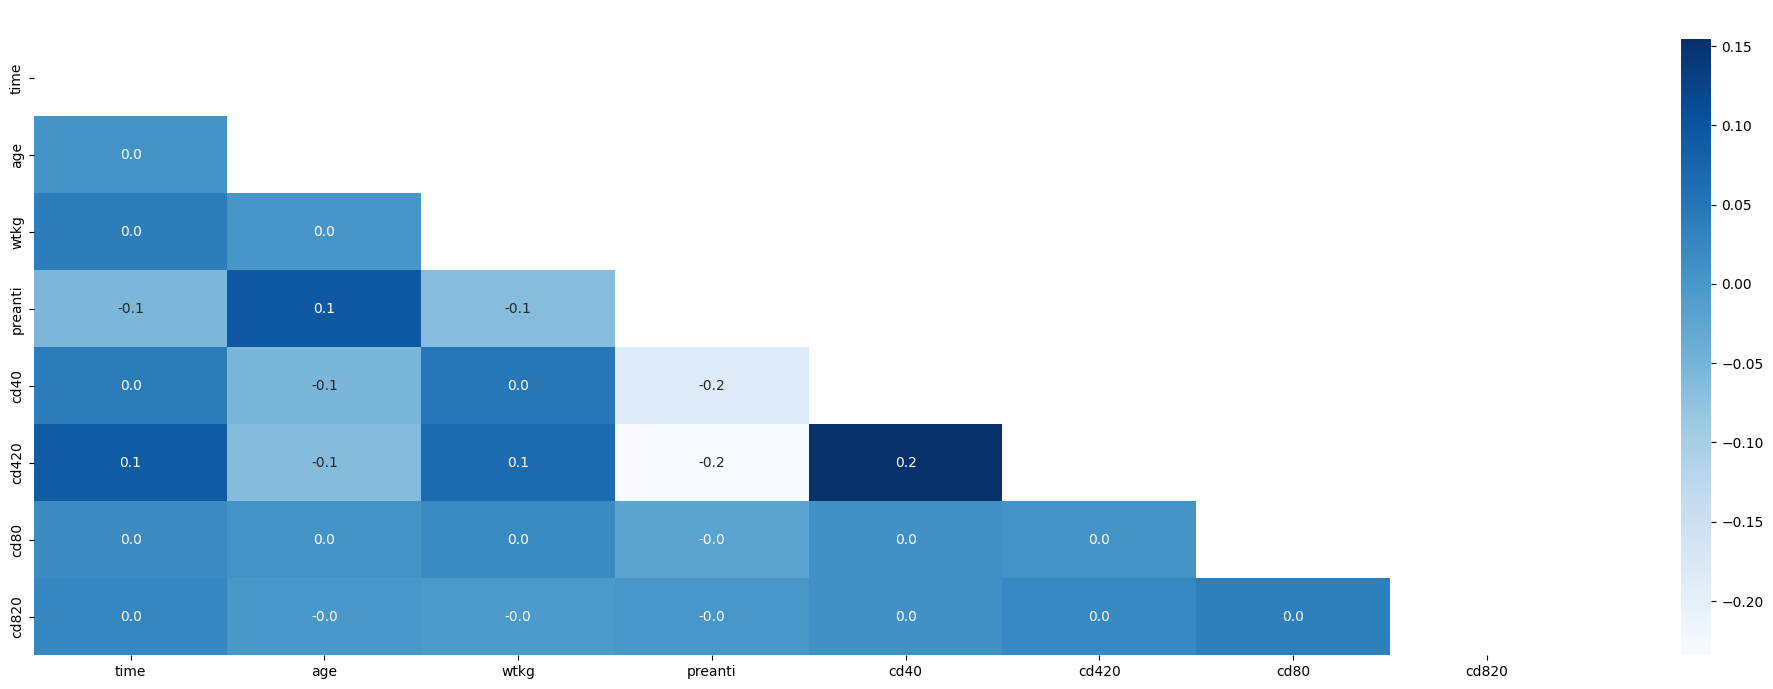

In [25]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=20,
             fontweight='bold', fontfamily='serif', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(
    df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='Blues')

plt.show()

In [30]:
X = df.iloc[:, :-1] #gán dữ liệu từ cột 0 đến n-1
Y = df.iloc[:, -1] #dùng cột 'infected' để làm nhãn

# thực hiện chia dữ liệu thành tập x và y
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=3, train_size=0.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35000, 22), (35000,), (15000, 22), (15000,))

In [31]:
#xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=14)

x_train, y_train = smote.fit_resample(x_train, y_train)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48260, 22), (48260,), (15000, 22), (15000,))

In [32]:
# chuẩn hoá dữ liệu
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

In [33]:
def objective(trial):
    params = {
        # Số vòng lặp tối đa
        'iterations': trial.suggest_int('iterations', 100, 1000), 
        # Tốc độ học
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5), 
        # Độ sâu của cây quyết định
        'depth': trial.suggest_int('depth', 1, 12),
        # Regularization L2 trên các lá
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        # Số lượng ngưỡng phân chia liên tục
        'border_count': trial.suggest_int('border_count', 1, 255),
        # Số luồng được sử dụng (để tối ưu hóa)
        'thread_count': -1,
        # Hàm mất mát (sử dụng 'MultiClass' cho bài toán phân loại đa lớp)
        'loss_function': 'MultiClass',
        # Tiêu chí đánh giá (sử dụng 'Accuracy' cho bài toán phân loại)
        'eval_metric': 'Accuracy',
        # Hiển thị quá trình huấn luyện
        'verbose': False
    }

    model = CatBoostClassifier(**params)

    model.fit(x_train, y_train, eval_set=(x_test, y_test),
              verbose=False, early_stopping_rounds=20)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-07-17 21:34:16,845] A new study created in memory with name: no-name-0d061c49-99e5-4790-8195-6d948c4f9307


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:34:19,867] Trial 0 finished with value: 0.6678 and parameters: {'iterations': 941, 'learning_rate': 0.19467620911941272, 'depth': 2, 'l2_leaf_reg': 0.0031708596664401403, 'border_count': 227}. Best is trial 0 with value: 0.6678.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:34:22,166] Trial 1 finished with value: 0.6558 and parameters: {'iterations': 129, 'learning_rate': 0.022728796741084783, 'depth': 4, 'l2_leaf_reg': 0.7463455230334183, 'border_count': 152}. Best is trial 0 with value: 0.6678.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:34:23,326] Trial 2 finished with value: 0.6604 and parameters: {'iterations': 835, 'learning_rate': 0.05409567232143027, 'depth': 8, 'l2_leaf_reg': 0.0012646362515279076, 'border_count': 154}. Best is trial 0 with value: 0.6678.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:34:35,887] Trial 3 finished with value: 0.6561333333333333 and parameters: {'iterations': 395, 'learning_rate': 0.3575807047193741, 'depth': 12, 'l2_leaf_reg': 0.0031146139352725005, 'border_count': 118}. Best is trial 0 with value: 0.6678.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:35:13,456] Trial 4 finished with value: 0.6697333333333333 and parameters: {'iterations': 936, 'learning_rate': 0.06041211672583012, 'depth': 11, 'l2_leaf_reg': 5.997735803776882, 'border_count': 211}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:35:16,096] Trial 5 finished with value: 0.6686666666666666 and parameters: {'iterations': 962, 'learning_rate': 0.11167181707451064, 'depth': 5, 'l2_leaf_reg': 0.7618518811528596, 'border_count': 65}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:35:18,598] Trial 6 finished with value: 0.6692666666666667 and parameters: {'iterations': 455, 'learning_rate': 0.3000153107496715, 'depth': 2, 'l2_leaf_reg': 0.014771171617434358, 'border_count': 246}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:35:56,135] Trial 7 finished with value: 0.6654666666666667 and parameters: {'iterations': 391, 'learning_rate': 0.08468814802336433, 'depth': 12, 'l2_leaf_reg': 0.0059017679094560144, 'border_count': 174}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:04,147] Trial 8 finished with value: 0.65 and parameters: {'iterations': 471, 'learning_rate': 0.02092311909519579, 'depth': 2, 'l2_leaf_reg': 0.002048972236813089, 'border_count': 198}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:06,376] Trial 9 finished with value: 0.6680666666666667 and parameters: {'iterations': 770, 'learning_rate': 0.26607867185913014, 'depth': 3, 'l2_leaf_reg': 6.514617925122129, 'border_count': 68}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:08,097] Trial 10 finished with value: 0.6624 and parameters: {'iterations': 681, 'learning_rate': 0.041109447675599244, 'depth': 9, 'l2_leaf_reg': 9.679721832802668, 'border_count': 9}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:09,104] Trial 11 finished with value: 0.6660666666666667 and parameters: {'iterations': 593, 'learning_rate': 0.11444583148252817, 'depth': 7, 'l2_leaf_reg': 0.049906181834555405, 'border_count': 255}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:12,952] Trial 12 finished with value: 0.6648 and parameters: {'iterations': 220, 'learning_rate': 0.4559416753849593, 'depth': 10, 'l2_leaf_reg': 0.03820462225415572, 'border_count': 246}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:13,705] Trial 13 finished with value: 0.6671333333333334 and parameters: {'iterations': 589, 'learning_rate': 0.013106173844568582, 'depth': 6, 'l2_leaf_reg': 0.3358389888369102, 'border_count': 212}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:15,916] Trial 14 finished with value: 0.6588 and parameters: {'iterations': 317, 'learning_rate': 0.19971365836798635, 'depth': 1, 'l2_leaf_reg': 0.015959288211840835, 'border_count': 193}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:18,508] Trial 15 finished with value: 0.6691333333333334 and parameters: {'iterations': 741, 'learning_rate': 0.03837156975117009, 'depth': 10, 'l2_leaf_reg': 0.20582965063336034, 'border_count': 102}. Best is trial 4 with value: 0.6697333333333333.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:22,241] Trial 16 finished with value: 0.6719333333333334 and parameters: {'iterations': 476, 'learning_rate': 0.14385811481018745, 'depth': 5, 'l2_leaf_reg': 2.3704495138030266, 'border_count': 228}. Best is trial 16 with value: 0.6719333333333334.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:25,466] Trial 17 finished with value: 0.6716666666666666 and parameters: {'iterations': 867, 'learning_rate': 0.13973609737379253, 'depth': 6, 'l2_leaf_reg': 2.8321055407610425, 'border_count': 172}. Best is trial 16 with value: 0.6719333333333334.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:27,393] Trial 18 finished with value: 0.672 and parameters: {'iterations': 539, 'learning_rate': 0.15015756325718815, 'depth': 6, 'l2_leaf_reg': 2.1317186529980767, 'border_count': 166}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:29,485] Trial 19 finished with value: 0.6696666666666666 and parameters: {'iterations': 532, 'learning_rate': 0.16830680967409523, 'depth': 4, 'l2_leaf_reg': 2.0180197743756665, 'border_count': 135}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:32,024] Trial 20 finished with value: 0.6678 and parameters: {'iterations': 271, 'learning_rate': 0.08424155977196857, 'depth': 7, 'l2_leaf_reg': 1.743803164923639, 'border_count': 179}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:34,951] Trial 21 finished with value: 0.6702 and parameters: {'iterations': 657, 'learning_rate': 0.12979562003258407, 'depth': 6, 'l2_leaf_reg': 2.7089989356346305, 'border_count': 165}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:37,466] Trial 22 finished with value: 0.6706 and parameters: {'iterations': 525, 'learning_rate': 0.1567220705674106, 'depth': 5, 'l2_leaf_reg': 0.7958767890100396, 'border_count': 223}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:39,910] Trial 23 finished with value: 0.6672 and parameters: {'iterations': 832, 'learning_rate': 0.2283179897946714, 'depth': 8, 'l2_leaf_reg': 3.207210728574652, 'border_count': 141}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:43,371] Trial 24 finished with value: 0.6707333333333333 and parameters: {'iterations': 634, 'learning_rate': 0.10962052749463805, 'depth': 5, 'l2_leaf_reg': 0.31084341174085545, 'border_count': 101}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:46,160] Trial 25 finished with value: 0.6682 and parameters: {'iterations': 455, 'learning_rate': 0.07847457787302027, 'depth': 4, 'l2_leaf_reg': 1.2433505295065108, 'border_count': 188}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:49,817] Trial 26 finished with value: 0.6668 and parameters: {'iterations': 387, 'learning_rate': 0.14252740628185556, 'depth': 8, 'l2_leaf_reg': 0.12673324555781848, 'border_count': 123}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:50,624] Trial 27 finished with value: 0.6707333333333333 and parameters: {'iterations': 744, 'learning_rate': 0.37888861971816834, 'depth': 6, 'l2_leaf_reg': 4.3084155543264755, 'border_count': 232}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:55,968] Trial 28 finished with value: 0.6698 and parameters: {'iterations': 873, 'learning_rate': 0.23560314676255095, 'depth': 7, 'l2_leaf_reg': 0.469750692540031, 'border_count': 204}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:36:58,730] Trial 29 finished with value: 0.6671333333333334 and parameters: {'iterations': 517, 'learning_rate': 0.1659931473908654, 'depth': 3, 'l2_leaf_reg': 1.2291249658827632, 'border_count': 231}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:02,259] Trial 30 finished with value: 0.6680666666666667 and parameters: {'iterations': 685, 'learning_rate': 0.09215050549373627, 'depth': 5, 'l2_leaf_reg': 9.907539918755022, 'border_count': 165}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:06,770] Trial 31 finished with value: 0.6694 and parameters: {'iterations': 591, 'learning_rate': 0.1144533828594536, 'depth': 5, 'l2_leaf_reg': 0.2931532916862261, 'border_count': 94}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:10,357] Trial 32 finished with value: 0.6676 and parameters: {'iterations': 640, 'learning_rate': 0.19489074918812568, 'depth': 4, 'l2_leaf_reg': 0.5432025452259576, 'border_count': 71}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:15,303] Trial 33 finished with value: 0.6646 and parameters: {'iterations': 160, 'learning_rate': 0.06035988264705443, 'depth': 6, 'l2_leaf_reg': 1.2946890983807093, 'border_count': 36}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:22,438] Trial 34 finished with value: 0.6709333333333334 and parameters: {'iterations': 330, 'learning_rate': 0.10164628159390976, 'depth': 3, 'l2_leaf_reg': 3.777909055925071, 'border_count': 151}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:27,262] Trial 35 finished with value: 0.6676666666666666 and parameters: {'iterations': 337, 'learning_rate': 0.0448752715690976, 'depth': 3, 'l2_leaf_reg': 3.8842598793920335, 'border_count': 155}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:27,818] Trial 36 finished with value: 0.6283333333333333 and parameters: {'iterations': 228, 'learning_rate': 0.06744754494481077, 'depth': 1, 'l2_leaf_reg': 2.2284316919346088, 'border_count': 148}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:33,002] Trial 37 finished with value: 0.6713333333333333 and parameters: {'iterations': 348, 'learning_rate': 0.09971213496170137, 'depth': 3, 'l2_leaf_reg': 5.884811950216533, 'border_count': 118}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:35,089] Trial 38 finished with value: 0.6695333333333333 and parameters: {'iterations': 487, 'learning_rate': 0.3292533806857121, 'depth': 8, 'l2_leaf_reg': 6.144533375053869, 'border_count': 114}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:42,408] Trial 39 finished with value: 0.6639333333333334 and parameters: {'iterations': 990, 'learning_rate': 0.03055472281602824, 'depth': 4, 'l2_leaf_reg': 0.7784575306763499, 'border_count': 84}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:45,480] Trial 40 finished with value: 0.6672666666666667 and parameters: {'iterations': 409, 'learning_rate': 0.13875023652985408, 'depth': 2, 'l2_leaf_reg': 5.8060035258318425, 'border_count': 129}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:48,114] Trial 41 finished with value: 0.6648666666666667 and parameters: {'iterations': 333, 'learning_rate': 0.09719874789489191, 'depth': 3, 'l2_leaf_reg': 3.100407101627128, 'border_count': 164}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:51,288] Trial 42 finished with value: 0.6654 and parameters: {'iterations': 423, 'learning_rate': 0.07283673534456585, 'depth': 3, 'l2_leaf_reg': 4.466672339999081, 'border_count': 114}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:53,439] Trial 43 finished with value: 0.6690666666666667 and parameters: {'iterations': 279, 'learning_rate': 0.12772102941192626, 'depth': 4, 'l2_leaf_reg': 1.5985777676942692, 'border_count': 180}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:37:59,372] Trial 44 finished with value: 0.6700666666666667 and parameters: {'iterations': 350, 'learning_rate': 0.05229312172368493, 'depth': 7, 'l2_leaf_reg': 6.1297729367958285, 'border_count': 147}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:38:01,501] Trial 45 finished with value: 0.6630666666666667 and parameters: {'iterations': 110, 'learning_rate': 0.09974620834789064, 'depth': 2, 'l2_leaf_reg': 1.012119613959236, 'border_count': 218}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:38:02,916] Trial 46 finished with value: 0.6696666666666666 and parameters: {'iterations': 427, 'learning_rate': 0.18469727428476296, 'depth': 5, 'l2_leaf_reg': 3.375356137817312, 'border_count': 155}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:38:04,633] Trial 47 finished with value: 0.6717333333333333 and parameters: {'iterations': 490, 'learning_rate': 0.23943830430196456, 'depth': 6, 'l2_leaf_reg': 2.18221148901059, 'border_count': 202}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:38:05,713] Trial 48 finished with value: 0.668 and parameters: {'iterations': 564, 'learning_rate': 0.2748876667883166, 'depth': 6, 'l2_leaf_reg': 9.70071022655066, 'border_count': 211}. Best is trial 18 with value: 0.672.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19172\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-17 21:38:08,455] Trial 49 finished with value: 0.6662666666666667 and parameters: {'iterations': 478, 'learning_rate': 0.23013442580009347, 'depth': 9, 'l2_leaf_reg': 0.0011188120267961032, 'border_count': 188}. Best is trial 18 with value: 0.672.


In [34]:
model = CatBoostClassifier(
    verbose=0,
    random_state=3,
    **study.best_params
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [35]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     10699
           1       0.42      0.46      0.44      4301

    accuracy                           0.67     15000
   macro avg       0.60      0.60      0.60     15000
weighted avg       0.67      0.67      0.67     15000



<Axes: >

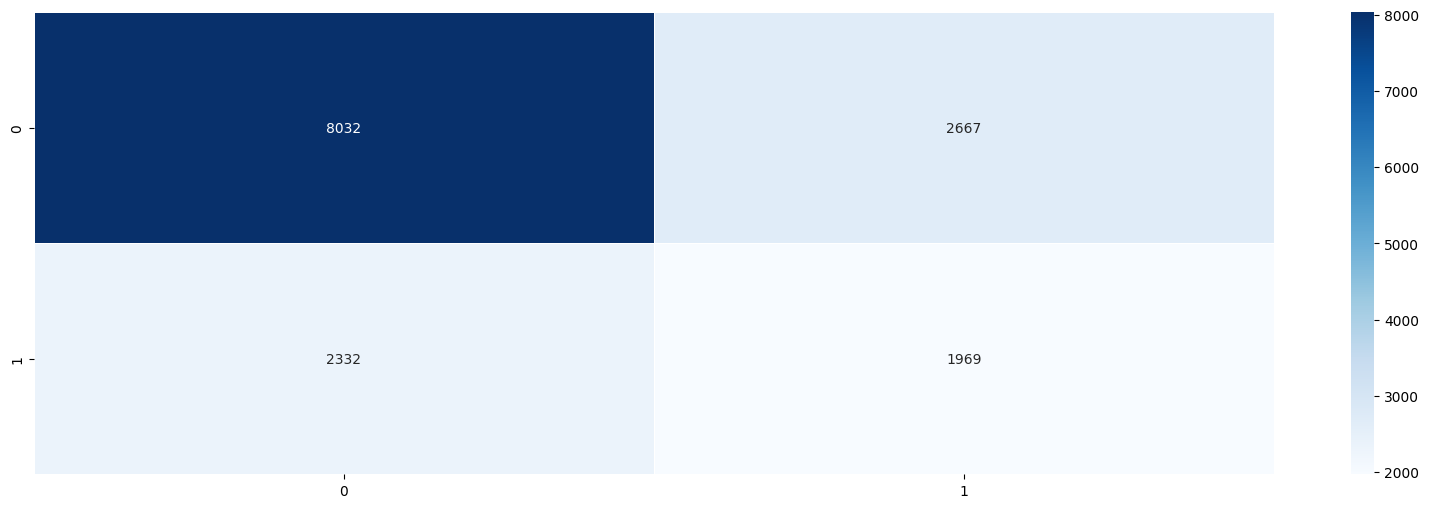

In [36]:
plt.subplots(figsize=(20, 6))

sns.heatmap(confusion_matrix(y_pred, y_test), annot=True,
            fmt="d", cmap="Blues", linewidths=.5)